In [12]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from pandas import DataFrame
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
from numpy import pi
import statsmodels.formula.api as smf
import shap
import copy
import sklearn.preprocessing as preprocessing
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns

# ICOS dataset

In [13]:
# Load data
f = open('/User/homes/czhan/BGI/work_3/ICOS_2020WarmWinter/EddyCovariance/Release_2/FLX_DE-Tha_FLUXNET2015_FULLSET_1996-2020_beta-3/FLX_DE-Tha_FLUXNET2015_FULLSET_DD_1996-2020_beta-3.csv')
ds =  pd.read_csv(f)

In [14]:
ds

,TIMESTAMP,TA_F_MDS,TA_F_MDS_QC,TA_F_MDS_NIGHT,TA_F_MDS_NIGHT_SD,TA_F_MDS_NIGHT_QC,TA_F_MDS_DAY,TA_F_MDS_DAY_SD,TA_F_MDS_DAY_QC,TA_ERA,...,GPP_DT_CUT_SE,GPP_DT_CUT_05,GPP_DT_CUT_16,GPP_DT_CUT_25,GPP_DT_CUT_50,GPP_DT_CUT_75,GPP_DT_CUT_84,GPP_DT_CUT_95,RECO_SR,RECO_SR_N
0,19960101,-6.317,1.0,-6.519,0.499,1.0,-5.947,0.363,1.0,-4.461,...,0.015053,0.555028,0.561730,0.577562,0.580810,0.640947,0.731020,0.831118,-9999,-9999
1,19960102,-8.194,1.0,-8.046,0.315,1.0,-8.462,0.136,1.0,-6.298,...,0.009923,0.367124,0.371160,0.381973,0.385200,0.422219,0.482865,0.549465,-9999,-9999
2,19960103,-6.493,1.0,-6.442,1.290,1.0,-6.585,0.543,1.0,-4.898,...,0.008910,0.329656,0.333276,0.342989,0.345897,0.379112,0.433579,0.493385,-9999,-9999
3,19960104,-5.817,1.0,-5.994,1.533,1.0,-5.494,0.416,1.0,-4.019,...,0.020099,0.729447,0.738346,0.751802,0.759671,0.853409,0.964941,1.094040,-9999,-9999
4,19960105,-7.153,1.0,-7.873,0.937,1.0,-5.840,1.314,1.0,-6.368,...,0.073735,2.243160,2.542880,2.569510,2.582920,3.043680,3.379220,3.798090,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9127,20201227,-1.100,1.0,-1.050,0.895,1.0,-1.199,0.568,1.0,-9999.000,...,0.045068,0.850156,0.887816,0.912788,1.064840,1.110250,1.546200,1.650990,-9999,-9999
9128,20201228,0.697,1.0,0.511,0.309,1.0,1.069,0.410,1.0,-9999.000,...,0.035154,0.411376,0.427144,0.473767,0.717211,0.788892,0.913247,1.116870,-9999,-9999
9129,20201229,1.987,1.0,1.183,0.844,1.0,3.596,1.207,1.0,-9999.000,...,0.039496,0.734143,0.765549,0.792913,0.934640,0.977202,1.334840,1.452930,-9999,-9999
9130,20201230,2.222,1.0,1.489,0.655,1.0,3.559,1.641,1.0,-9999.000,...,0.048202,1.023330,1.043830,1.054690,1.143620,1.187410,1.695690,1.766070,-9999,-9999


In [15]:
# check the dataset
# select time period
ds['time'] = pd.date_range(start='1996-01-01', end='2020-12-31', freq='D')
ds = ds.reset_index().set_index('time')
ds = ds[(ds.index.year<2020)&(ds.index.year>1996)]

In [16]:
# Train the model with the first half dataset
# Predict GPP with the second half dataset

ds_train = ds[ds.index.year<2007]
ds_predict = ds[ds.index.year>=2007]

data_train =pd.concat([ds_train['VPD_F_MDS'],ds_train['TA_F_DAY'],ds_train['SW_IN_F_MDS'],ds_train['SWC_F_MDS_1'],ds_train['GPP_NT_VUT_REF']],axis=1)
data_predict =pd.concat([ds_predict['VPD_F_MDS'],ds_predict['TA_F_DAY'],ds_predict['SW_IN_F_MDS'],ds_predict['SWC_F_MDS_1'],ds_predict['GPP_NT_VUT_REF']],axis=1)
data_train.columns = ['VPD','T','SWR','SM','GPP']
data_predict.columns = ['VPD','T','SWR','SM','GPP']


In [17]:
# Train the model
x = data_train.iloc[:,:-1]
y = data_train.iloc[:,-1]
model = RandomForestRegressor(oob_score=True)

estimator = model.fit(x,y)
GPP_p = estimator.predict(data_predict.iloc[:,:-1])
oob = model.oob_score_
oob

0.859228599149274

In [31]:
# add the predicted GPP in a dataframe
GPP_rf = pd.DataFrame(index = data_predict.index,data = GPP_p, columns = {'GPP_predict'})

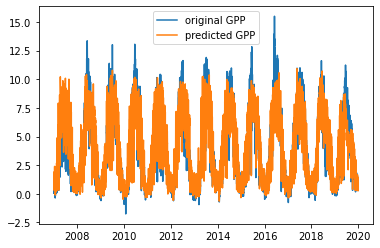

In [32]:
plt.plot(data_predict['GPP'],label = 'original GPP')
plt.plot(GPP_rf['GPP_predict'],label = 'predicted GPP')
plt.legend()

In [33]:
# Select one year
df = GPP_rf[GPP_rf.index.year==2008]

<AxesSubplot:xlabel='time'>

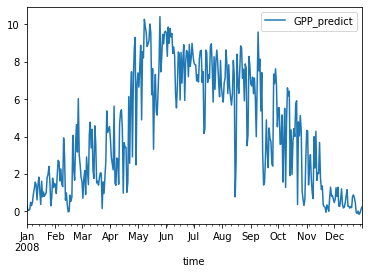

In [34]:
df.plot()

# Feature importance

Text(0.5, 1.0, 'Feature importance')

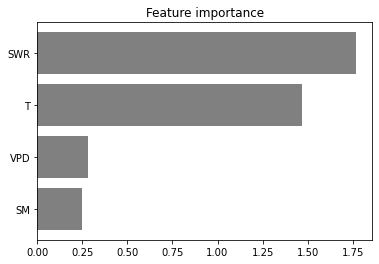

In [9]:
# shap value
explainer = shap.TreeExplainer(model)
shap_values = explainer(x)
output = np.nanmean(abs(shap_values.values),axis=0)
de = pd.DataFrame({'Features':['VPD','T','SWR','SM'], 'Importance':output}).set_index('Features')
de = de.sort_values(by='Importance', ascending=True)
plt.barh(de.index,de['Importance'],color='grey')
plt.title('Feature importance')